In [4]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
from imblearn import  over_sampling

Using TensorFlow backend.


In [6]:
print(os.getcwd())

C:\Users\xingxuan_dell\1UCD_MSBA\BAX 452\Homework2


## Reading the Data

In [7]:
income = pd.read_csv(r"D:/Winter 2020/BAX 452 Machine Learning/Homework 2/income_data.csv", sep=r'\s*,\s*', engine='python')
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Basic EDA and Transformations

In [8]:
factors = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

In [9]:
#Checking for nulls
income.isnull().values.any()

False

In [10]:
#in case nulls need to be handled
for factor in factors:
    income[factor].fillna(value=income[factor].mode()[0], inplace=True)

In [11]:
income['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [12]:
#merging levels of education
income['education']=np.where(income['education'] =='11th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='9th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='7th-8th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='5th-6th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='10th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='1st-4th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='Preschool', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='12th', 'Not-HS-Grad', income['education'])

In [13]:
#assigning levels to the values of categorical variables
income_fact = income.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,2,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,2,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,4,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,6,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,2,13,2,10,5,2,0,0,0,40,5,0


In [18]:
#correlation matrix of the data
income_fact_corr=round(income_fact.corr(),3)
income_fact_corr

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
age,1.000,0.004,-0.077,-0.063,0.037,-0.266,-0.021,-0.264,0.029,0.089,0.078,0.058,0.069,-0.001,0.234
workclass,0.004,1.000,-0.017,-0.027,0.052,-0.065,0.255,-0.090,0.050,0.096,0.034,0.012,0.139,-0.008,0.052
fnlwgt,-0.077,-0.017,1.000,0.009,-0.043,0.028,0.002,0.009,-0.021,0.027,0.000,-0.010,-0.019,-0.052,-0.009
education,-0.063,-0.027,0.009,1.000,-0.362,0.052,-0.052,0.070,-0.015,-0.029,-0.013,-0.024,-0.097,-0.003,-0.118
education-num,0.037,0.052,-0.043,-0.362,1.000,-0.069,0.110,-0.094,0.032,0.012,0.123,0.080,0.148,0.051,0.335
marital-status,-0.266,-0.065,0.028,0.052,-0.069,1.000,-0.010,0.185,-0.068,-0.129,-0.043,-0.034,-0.191,-0.024,-0.199
occupation,-0.021,0.255,0.002,-0.052,0.110,-0.010,1.000,-0.076,0.007,0.080,0.026,0.018,0.080,-0.013,0.075
relationship,-0.264,-0.090,0.009,0.070,-0.094,0.185,-0.076,1.000,-0.116,-0.582,-0.058,-0.061,-0.249,-0.006,-0.251
race,0.029,0.050,-0.021,-0.015,0.032,-0.068,0.007,-0.116,1.000,0.087,0.011,0.019,0.042,0.138,0.072
sex,0.089,0.096,0.027,-0.029,0.012,-0.129,0.080,-0.582,0.087,1.000,0.048,0.046,0.229,-0.008,0.216


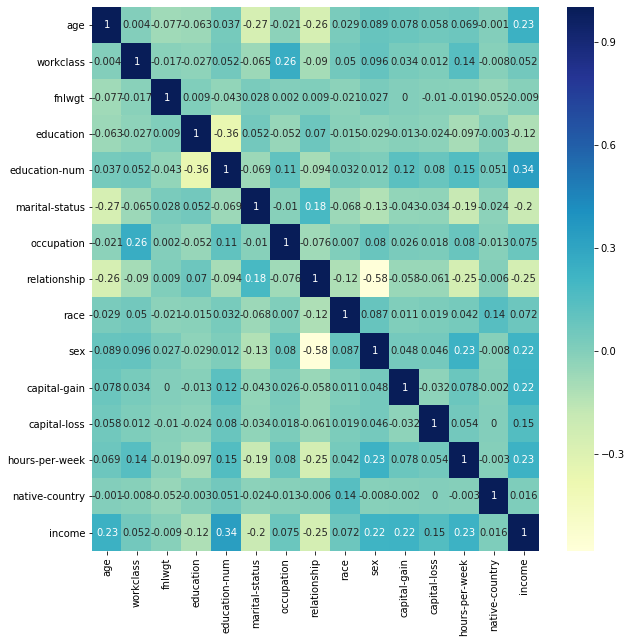

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(income_fact_corr, annot=True,cmap="YlGnBu")

In [22]:
#checking for class imbalance
print(income['income'].value_counts())
print(str(round(income['income'].value_counts()[1]*100/income.shape[0],2)) + '%')

<=50K    24720
>50K      7841
Name: income, dtype: int64
24.08%


Text(0, 0.5, 'High Salary')

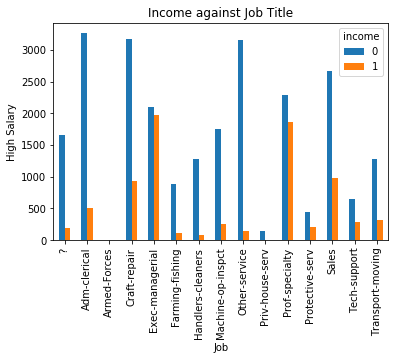

In [23]:
#determining if a variable is good predictor of income through plots
%matplotlib inline
pd.crosstab(income['occupation'],income_fact['income']).plot(kind='bar')
plt.title('Income against Job Title')
plt.xlabel('Job')
plt.ylabel('High Salary')

## Creating Dummy Variables

In [24]:
for var in factors:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income[var], prefix=var)
        income = pd.concat([income,cat_list], axis = 1)
        income = income.drop(var, 1)
income.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Test-Training Set Split and Fitting

In [25]:
#70% records being sent into training set 
income['income'] = income['income'].factorize()[0]
pts = np.random.rand(len(income)) < 0.7

income_train = income[pts]
income_test = income[~pts]

X_train = income_train.copy()
X_train = X_train.drop('income', 1)
Y_train = income_train['income']

#fitting the model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
#generating confusion matrix
X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']
Y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[7136  237]
 [1751  602]]
